# Data Loading

## Download datasets dan unzip

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sunilgautam/movielens


mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 95.7MB/s]


In [ ]:
! unzip "movielens.zip"

Archive:  movielens.zip
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/movies.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/tags.csv  


## Import Library yang dibutuhkan

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')
movies = pd.read_csv('/content/ml-latest-small/movies.csv')

# Data Understanding

## Memastikan movies dan rating termuat dengan baik

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Melihat detail dari movies dan ratings

In [ ]:
movies.info()
print('\n')
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## Shape dari movies dan ratings

In [ ]:
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


Terlhat bahwa movies terdapat 3 kolom dan 9742 baris dan ratings terdapat 4 kolom 100836 baris

## Mengecek Missing Value

In [ ]:
print(movies.isnull().sum())
print('\n')
print(ratings.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Tidak ada *Missing Value* baik di movies dan di ratings

## Mengecek data duplikat

In [ ]:
print(movies.duplicated().sum())
print(ratings.duplicated().sum())

0
0


Tidak ada data duplikat baik di movies dan ratings

## Menghitung Data Unik

In [ ]:
print(movies.nunique())
print('\n')
print(ratings.nunique())

movieId    9742
title      9737
genres      951
dtype: int64


userId         610
movieId       9724
rating          10
timestamp    85043
dtype: int64


Pada variabel movies terdaoat 9742 movieId, 9737 title, dan 951 genres unik.
Pada variabel ratings terdaoat 610 userId, 9724 movieId, 10 rating, dan 85043 timestamp unik.

## Mengecek sebaran rating

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64


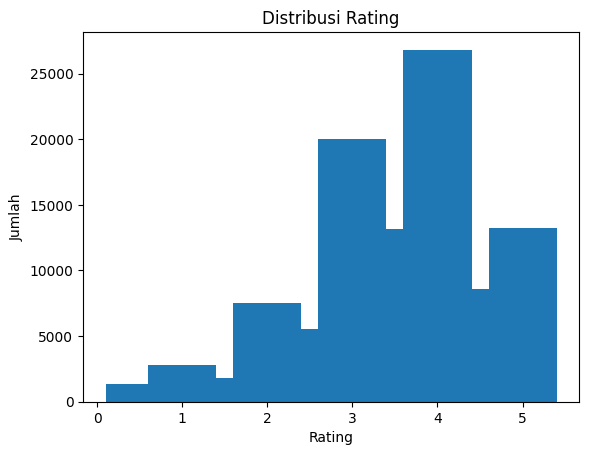

In [ ]:
print(ratings.rating.value_counts());
ratings_counts = ratings.rating.value_counts()

# Mengambil index (nilai rating) dan nilai (jumlah rating)
ratings_index = ratings_counts.index
ratings_values = ratings_counts.values

# Membuat plot distribusi
plt.bar(ratings_index, ratings_values)

# Menambahkan judul dan label sumbu
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')

# Menampilkan plot
plt.show()



Terlihat sebaran ratings kelipatan 0.5 dengan rating terendah 0.5 dan rating tertinggi 5.0

## Analisa Distribusi Tahun Rilis

In [ ]:
movies_year = movies.copy()
movies_year['year'] = movies['title'].str.extract('(\d+)').astype(float)
movies_year.year.dropna(inplace=True)

Membuat variabel __movies_year__ dan mengekstract judul dari variabel __movies__ dan drop *missing value*

In [ ]:
new_movies_year = movies_year[(movies_year['year'] > 1800.0) & (movies_year['year'] < 2100.0)]
new_movies_year.year.astype(int)
data = new_movies_year

Melakukan filter tahun antara setelah 1800 dan 2100

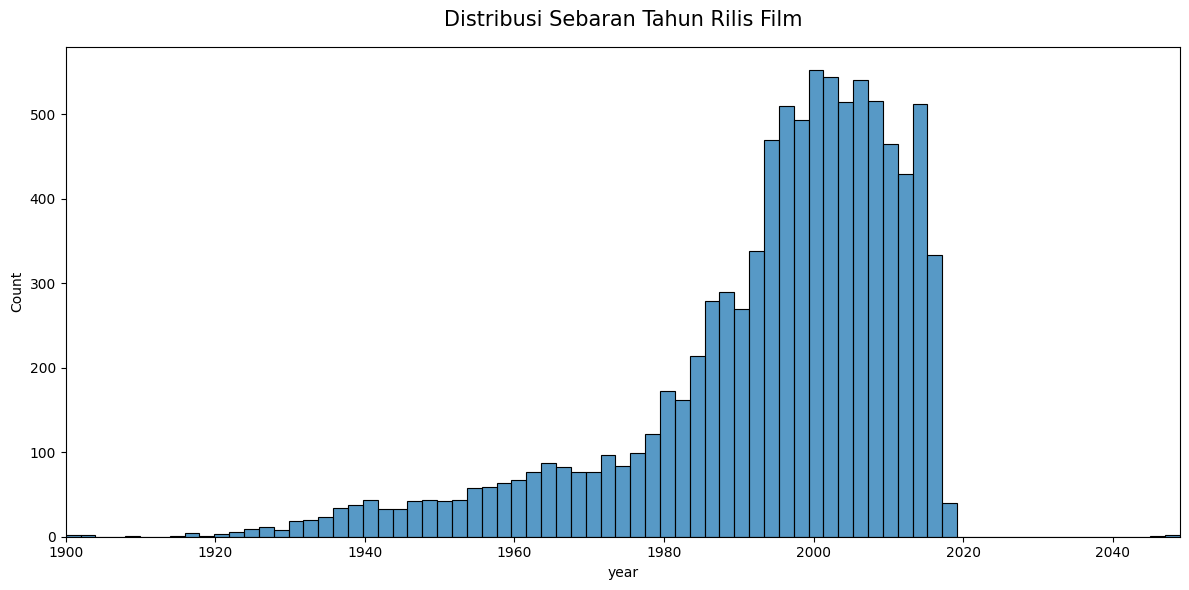

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(data=data, x='year')
plt.title('Distribusi Sebaran Tahun Rilis Film', fontsize=15, pad=15)
plt.xlim(min(data['year']), max(data['year']))
plt.tight_layout()
plt.show()

Terlihat sebaran tahun rilis film paling banyak di tahun 2000-an

## Analisa Distribusi Genre Film

In [ ]:
movies_genres = movies.copy()
genres=[]
for i in range(len(movies.genres)):
    for x in movies.genres[i].split('|'):
        if x not in genres:
            genres.append(x)
genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']

Mengekstrak genre, genre di dataset untuk satu film bisa lebih dari satu dan dipisahkan dengan '|'

In [ ]:
for x in genres:
    movies_genres[x] = 0

for i in range(len(movies.genres)):
    for x in movies.genres[i].split('|'):
        movies_genres[x][i]=1

movies_genres.head()

<ipython-input-9-90dbf4d5d12b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_genres[x][i]=1


,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Untuk genre buat *One Hot Encoding* untuk memudahkan pengelohan data

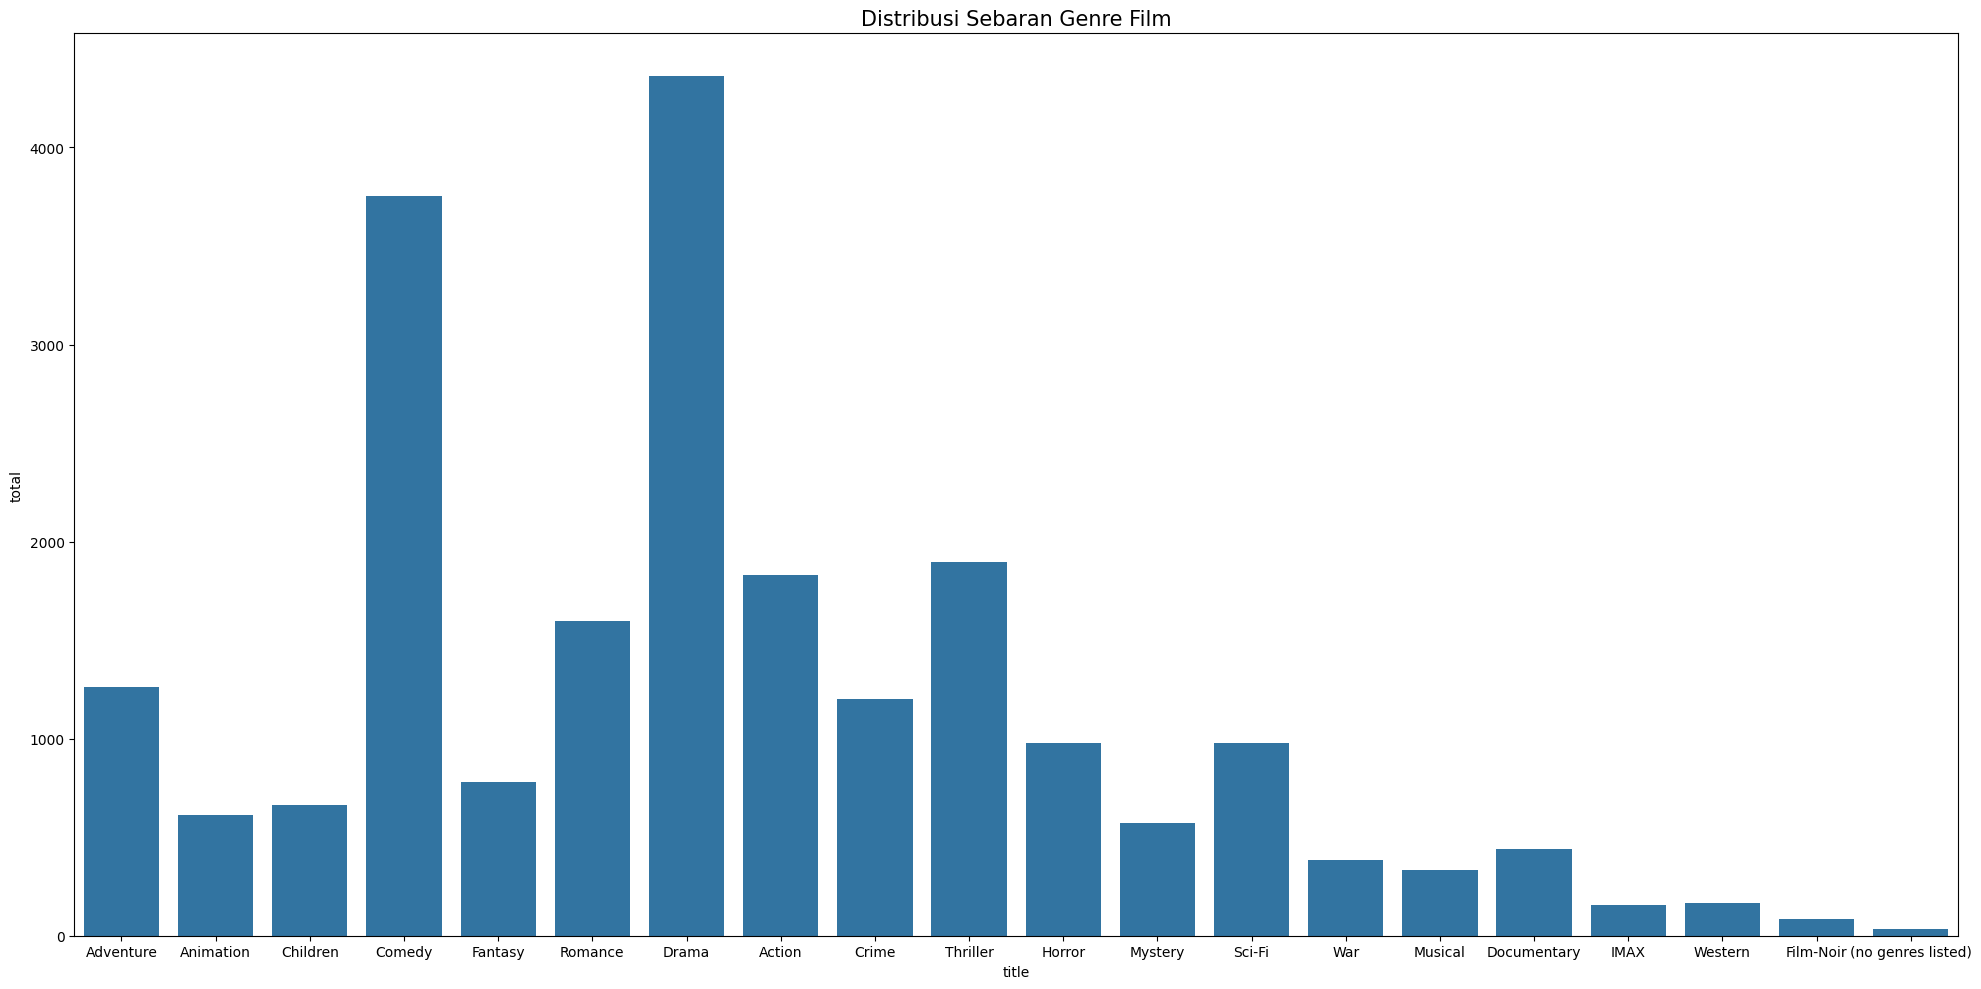

In [ ]:
data = movies_genres.iloc[:,3:].sum().reset_index()
data.columns = ['title','total']

plt.figure(figsize=(20,10))
sns.barplot(x='title', y='total', data=data)
plt.title('Distribusi Sebaran Genre Film', fontsize=15)
plt.tight_layout()
plt.show()

Terlihat sebaran genre di dataset, yang terbanyak adalah **Drama** diikuti dengan **Comedy**

## Analisa Rating

In [ ]:
# Jumlah pengguna yang memberikan rating
jumlah_pengguna = len(ratings['userId'].unique())

# Jumlah film yang diberi rating oleh pengguna
jumlah_film = len(ratings['movieId'].unique())

print(f'Jumlah pengguna yang memberikan rating: {jumlah_pengguna}')
print(f'Jumlah film yang diberi rating oleh pengguna: {jumlah_film}')


Jumlah pengguna yang memberikan rating: 610
Jumlah film yang diberi rating oleh pengguna: 9724


In [ ]:
rating_movies = pd.merge(ratings, movies, on='movieId', how='inner')
rating_movies.drop(['timestamp','genres'],axis=1, inplace=True)
rating_movies.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


merge ratings dan movies berdasar __movieId__ drop *timestamp* dan *genres* yang tidak diperlukan pada analisa rating kali ini

In [ ]:
rating_movies_count = rating_movies.groupby('title')['rating'].count()
rating_movies_count = pd.DataFrame(rating_movies_count).reset_index().rename(columns={'rating':'total_rating'})
rating_movies_count.head()

,title,total_rating
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


Kelompokkan berdasarkan judul untuk melihat rating yang diperoleh suatu film

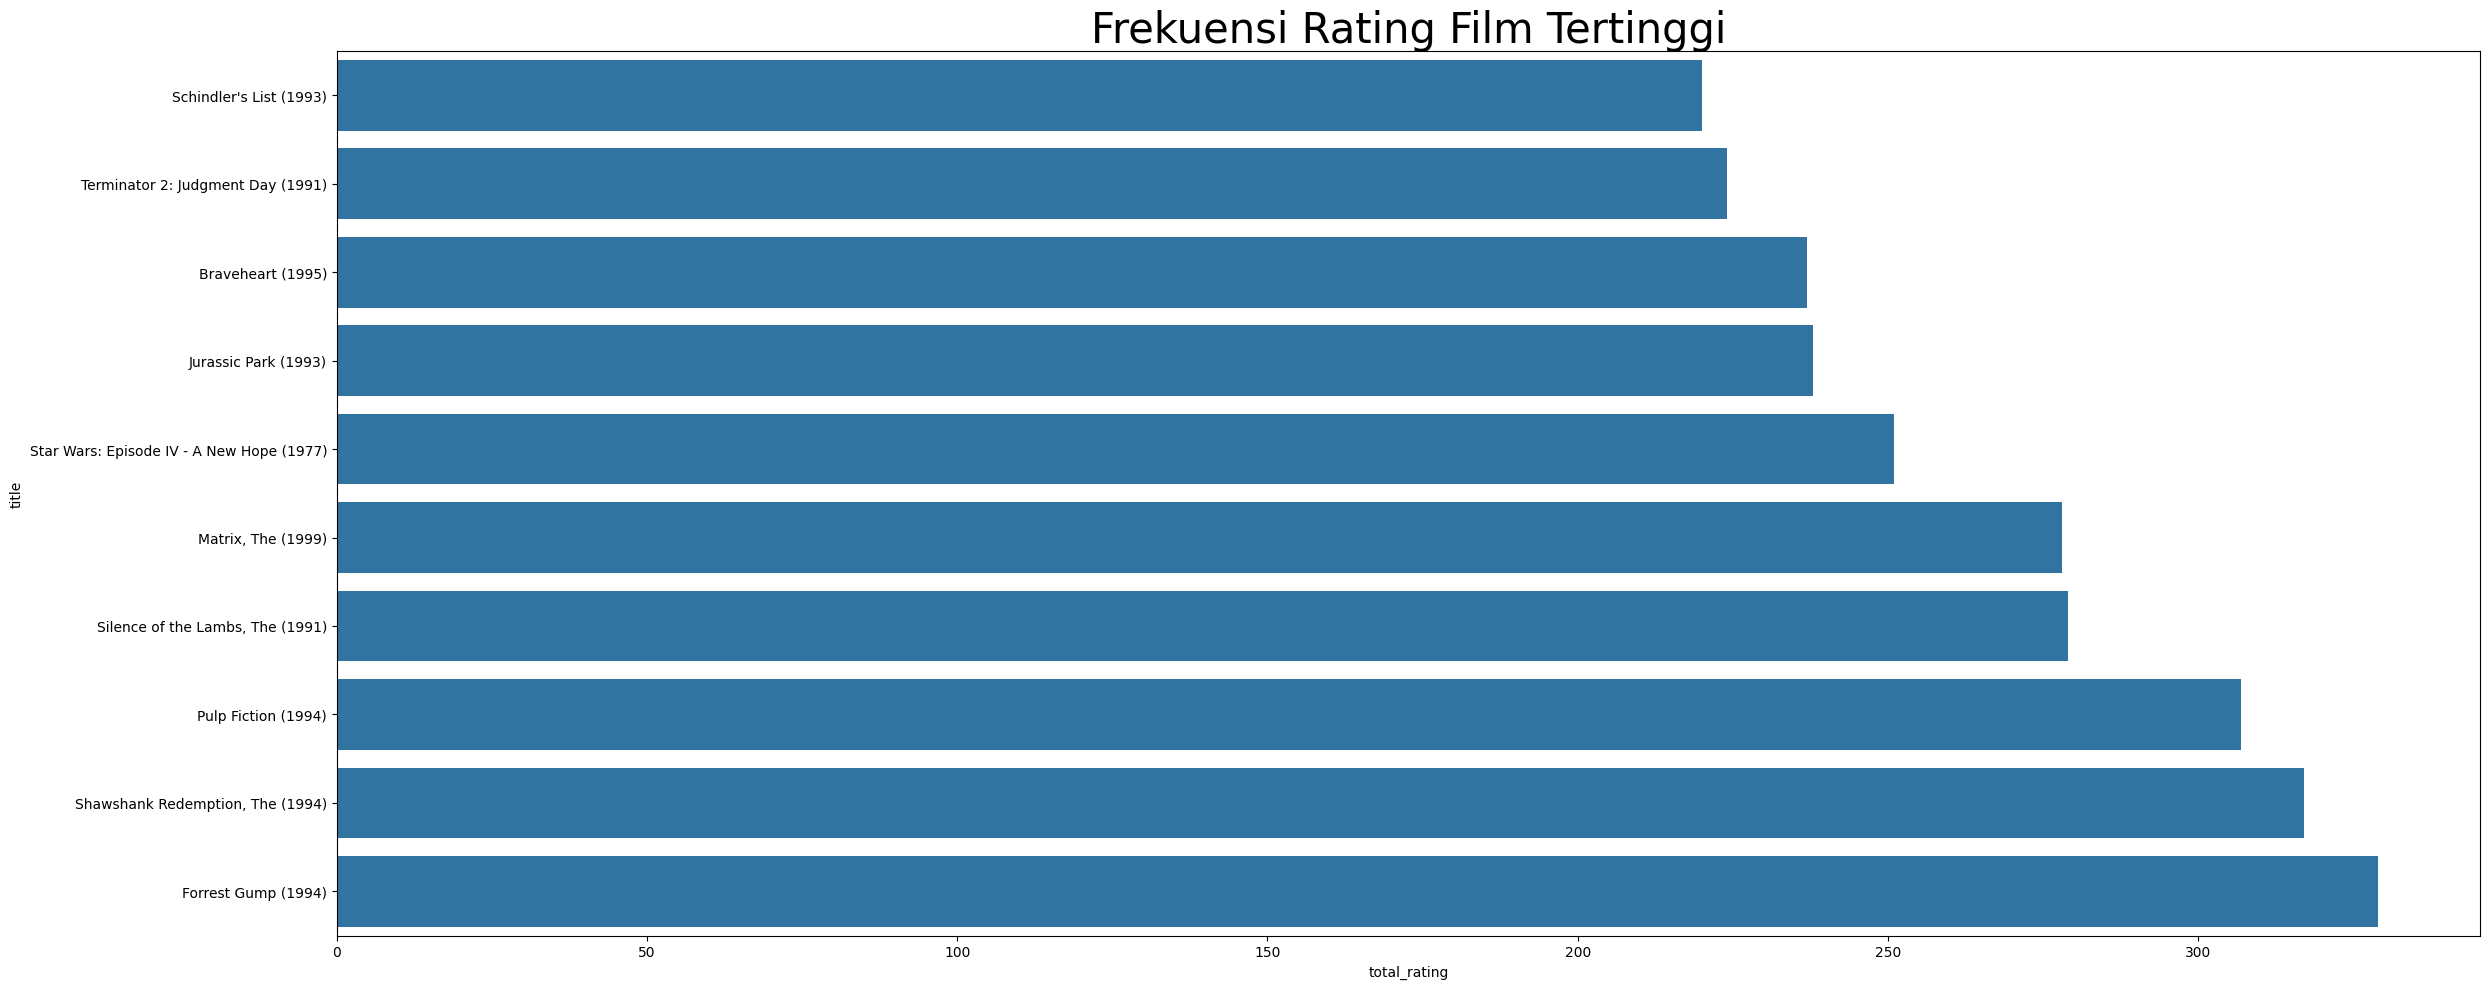

In [ ]:
data = rating_movies_count.sort_values(by ='total_rating')

plt.figure(figsize=(25,10))
sns.barplot(data=data.iloc[-10:,:],
            y='title', x='total_rating',
            )
plt.title('Frekuensi Rating Film Tertinggi', pad=0, fontsize=30)
plt.tight_layout()
plt.show()

Terlihat bahwa film yang paling banyak dirating adalah __Forrest Gump(1994)__

# Data Preparation

## Membersihkan *Missing Value*

In [ ]:
movies.dropna(axis=0, inplace=True)
ratings.dropna(axis=0, inplace=True)

## Sorting Rating Berdasarkan userId

In [ ]:
ratings = ratings.sort_values('userId').astype('int')

## Drop Data Duplikat

In [ ]:
movies.drop_duplicates(subset=['title'], keep='first', inplace=True)
ratings.drop_duplicates(subset=['userId','movieId'], keep='first', inplace=True)

## Menggabungkan Data

In [ ]:
merge_df = pd.merge(ratings, movies, how='left', on='movieId')
df = merge_df.copy().drop('timestamp', axis=1)
df.head()

,userId,movieId,rating,title,genres
0,1,1,4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,2329,5,American History X (1998),Crime|Drama
2,1,2338,2,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller
3,1,2353,5,Enemy of the State (1998),Action|Thriller
4,1,2366,4,King Kong (1933),Action|Adventure|Fantasy|Horror


Menggabungkan ratings dan movies berdasarkan *MovieId*

In [ ]:
df = df[~pd.isnull(df['genres'])]
df.shape

(100830, 5)

Menghapus data *null* dan melihat *shape* akhir, terdapat 100830 baris dan 5 kolom

# Model Development

## Content Based Filtering

In [ ]:
tfid = TfidfVectorizer(stop_words='english')
tfid.fit(movies['genres'])
tfid.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

Melakukan inisialisasi TF-IDF dan melakukan mapping

## Ubah Data ke Bentuk Matriks

In [ ]:
tfidf_matrix = tfid.fit_transform(movies['genres'])
tfidf_matrix.shape

(9742, 23)

## Menghitung cosine similarity

In [ ]:
cos_similar = cosine_similarity(tfidf_matrix)
cos_similar

array([[1.        , 0.81357774, 0.15276924, ..., 0.        , 0.4210373 ,
        0.26758648],
       [0.81357774, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15276924, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57091541],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.4210373 , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26758648, 0.        , 0.57091541, ..., 0.        , 0.        ,
        1.        ]])

## Membuat Dataframe cosine similarity

In [ ]:
cos_similar = pd.DataFrame(cos_similar, index=movies['title'],
                             columns=movies['title'])
cos_similar

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.813578,0.152769,0.135135,0.267586,0.000000,0.152769,0.654698,0.000000,0.262413,...,0.360397,0.465621,0.196578,0.516225,0.0,0.680258,0.755891,0.000000,0.421037,0.267586
Jumanji (1995),0.813578,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.804715,0.000000,0.322542,...,0.000000,0.000000,0.000000,0.000000,0.0,0.341376,0.379331,0.000000,0.000000,0.000000
Grumpier Old Men (1995),0.152769,0.000000,1.000000,0.884571,0.570915,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.162848,0.000000,0.419413,0.000000,0.0,0.181883,0.202105,0.000000,0.000000,0.570915
Waiting to Exhale (1995),0.135135,0.000000,0.884571,1.000000,0.505015,0.000000,0.884571,0.000000,0.000000,0.000000,...,0.144051,0.201391,0.687440,0.000000,0.0,0.160888,0.178776,0.466405,0.000000,0.505015
Father of the Bride Part II (1995),0.267586,0.000000,0.570915,0.505015,1.000000,0.000000,0.570915,0.000000,0.000000,0.000000,...,0.285240,0.000000,0.734632,0.000000,0.0,0.318581,0.354002,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.680258,0.341376,0.181883,0.160888,0.318581,0.239513,0.181883,0.000000,0.436010,0.241142,...,0.599288,0.554355,0.234040,0.614603,0.0,1.000000,0.899942,0.000000,0.753553,0.318581
No Game No Life: Zero (2017),0.755891,0.379331,0.202105,0.178776,0.354002,0.000000,0.202105,0.000000,0.000000,0.000000,...,0.476784,0.615990,0.260061,0.682937,0.0,0.899942,1.000000,0.000000,0.557008,0.354002
Flint (2017),0.000000,0.000000,0.000000,0.466405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.431794,0.678466,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000


Terlihat nilai *cosine similarity* untuk tiap film

## Uji Coba Model Content Based Filtering

### Fungsi untuk mendapatkan 10 film dengan kemiripan tertinggi berdasarkan cosine similarity

In [ ]:
def MovieRecommendations(movies_title, similarity_data=cos_similar,
                         items=movies[['movieId','title','genres']], k=10):

    index = similarity_data.loc[:, movies_title].to_numpy().argpartition(
        range(-1, -k, -1)
    )

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(movies_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Mengambil 10 data dengan nilai *cosine similarity* terbesar dan drop dirinya sendiri agar tidak muncul dalam daftar rekomendasi

## Menguji Model Rekomendasi

In [ ]:
find_title = movies[movies['title'] == 'Flint (2017)']
find_title

,movieId,title,genres
9739,193585,Flint (2017),Drama


In [ ]:
movie_title = 'Flint (2017)'
movie_recomend = MovieRecommendations(movie_title)
movie_recomend

,title,movieId,genres
0,Monsieur Ibrahim (Monsieur Ibrahim et les fleu...,7299,Drama
1,Proof (2005),36527,Drama
2,Miss Meadows (2014),117107,Drama
3,Melvin and Howard (1980),2988,Drama
4,Bringing Out the Dead (1999),2976,Drama
5,Body Shots (1999),2979,Drama
6,Songs From the Second Floor (Sånger från andra...,5515,Drama
7,If These Walls Could Talk (1996),70990,Drama
8,Radio Flyer (1992),7030,Drama
9,Get on the Bus (1996),1054,Drama


Terlihat dari 10 film yang direkomendasikan, semuanya memilki genre yang sama dengan 'Flint (2017)' yaitu drama.

## Collaborative Filtering

### Encoding useId dan movieId

In [ ]:
user_id = df['userId'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_id)}
user_encoded_to_user = {i: x for i, x in enumerate(user_id)}

In [ ]:
movie_id = df['movieId'].unique().tolist()
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_id)}
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_id)}

### Mapping user dan movie dengan Encoded user dan movie

In [ ]:
df['user'] = df['userId'].map(user_to_user_encoded)
df['movie'] = df['movieId'].map(movie_to_movie_encoded)
df.head()

,userId,movieId,rating,title,genres,user,movie
0,1,1,4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0
1,1,2329,5,American History X (1998),Crime|Drama,0,1
2,1,2338,2,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller,0,2
3,1,2353,5,Enemy of the State (1998),Action|Thriller,0,3
4,1,2366,4,King Kong (1933),Action|Adventure|Fantasy|Horror,0,4


In [ ]:
num_users = len(user_to_user_encoded)
num_movie = len(movie_encoded_to_movie)
df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

print(f'Banyaknya user: {num_users}')
print(f'Banyaknya movie: {num_movie}')
print(f'Rating tertinggi: {min_rating}')
print(f'Rating terendah: {max_rating}')

Banyaknya user: 610
Banyaknya movie: 9719
Rating tertinggi: 0.0
Rating terendah: 5.0


In [ ]:
df = df.sample(frac=1, random_state=12)
df.head()

,userId,movieId,rating,title,genres,user,movie
70844,453,3326,5.0,What Planet Are You From? (2000),Comedy|Sci-Fi,452,2611
45910,304,1073,4.0,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical,303,207
85046,552,597,2.0,Pretty Woman (1990),Comedy|Romance,551,468
48455,313,196,4.0,Species (1995),Horror|Sci-Fi,312,706
48344,313,4855,3.0,Dirty Harry (1971),Action|Crime|Thriller,312,2131


### Pembagian Data untuk Training dan Validasi

In [ ]:
x = df[['user', 'movie']].values
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

membagi data train sebesar 80% dan data validasi sebesar 20%

### Pelatihan Model

#### Pembuatan Fungsi

In [ ]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size

    # Embedding layers
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.movie_embedding = layers.Embedding(
        num_movies,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )

    # Bias layers
    self.user_bias = layers.Embedding(num_users, 1)
    self.movie_bias = layers.Embedding(num_movies, 1)

    # Output layer
    self.output_layer = layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:, 0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])

    # Dot product of user and movie embeddings
    dot_user_movie = tf.tensordot(user_vector, movie_vector, axes=2)

    # Combine embeddings and biases
    x = dot_user_movie + user_bias + movie_bias

    # Apply output layer
    return self.output_layer(x)

#### Kompilasi dan Konfigurasi Model

In [ ]:
model = RecommenderNet(num_users, num_movie, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[[tf.keras.metrics.MeanAbsoluteError(name='mae'),tf.keras.metrics.RootMeanSquaredError(name='rmse')]]
)
callbacks = EarlyStopping(
    min_delta=0.0001,
    patience=7,
    restore_best_weights=True,
)

#### Training Model

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 20,
    validation_data = (x_val, y_val),
    callbacks=[callbacks]
)

Epoch 1/20
10083/10083 [==============================] - 49s 5ms/step - loss: 0.6023 - mae: 0.1403 - rmse: 0.1815 - val_loss: 0.6070 - val_mae: 0.1457 - val_rmse: 0.1878
Epoch 2/20
10083/10083 [==============================] - 40s 4ms/step - loss: 0.6003 - mae: 0.1379 - rmse: 0.1789 - val_loss: 0.6065 - val_mae: 0.1443 - val_rmse: 0.1870
Epoch 3/20
10083/10083 [==============================] - 45s 4ms/step - loss: 0.5989 - mae: 0.1364 - rmse: 0.1771 - val_loss: 0.6060 - val_mae: 0.1444 - val_rmse: 0.1864
Epoch 4/20
10083/10083 [==============================] - 41s 4ms/step - loss: 0.5980 - mae: 0.1354 - rmse: 0.1760 - val_loss: 0.6060 - val_mae: 0.1437 - val_rmse: 0.1862
Epoch 5/20
10083/10083 [==============================] - 40s 4ms/step - loss: 0.5970 - mae: 0.1343 - rmse: 0.1746 - val_loss: 0.6053 - val_mae: 0.1437 - val_rmse: 0.1855
Epoch 6/20
10083/10083 [==============================] - 45s 4ms/step - loss: 0.5963 - mae: 0.1336 - rmse: 0.1738 - val_loss: 0.6053 - val_mae: 

### Uji Coba Model Collaborative Filtering

#### Mengambil sample userId

In [ ]:
user_ID = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_ID]

movie_not_watched = movies[~movies['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)


movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_ID)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

#### Menguji Model Collaborative Filtering

In [ ]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Rekomendasi untuk user {}'.format(user_ID))
print('\nmovie with high ratings')

top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movies[movies['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title)


print('\nTop movies recommendation: ')

recommended_movie = movies[movies['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title)

274/274 [==============================] - 1s 3ms/step
Rekomendasi untuk user 307

movie with high ratings
Army of Darkness (1993)
American Psycho (2000)
Reign Over Me (2007)
Iron Man (2008)
WALL·E (2008)

Top movies recommendation: 
Streetcar Named Desire, A (1951)
Brazil (1985)
12 Angry Men (1957)
Apocalypse Now (1979)
Ran (1985)
Grand Day Out with Wallace and Gromit, A (1989)
Glory (1989)
Seven Samurai (Shichinin no samurai) (1954)
Guess Who's Coming to Dinner (1967)
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)


# Evaluasi

Metriks yang digunakan adalah *Mean Absolute Error* (MAE) dan *Root Mean Squared Error* (RMSE) pada *Collaborative Filtering* dan *Precision* dan *recall* pada *Content Based Filtering*

## Content Based Filtering

In [ ]:
def precision(recommended_movies, relevant_movies, k=10):
    recommended_movies = recommended_movies['title'].tolist()[:k]
    relevant_recommended = [movie for movie in recommended_movies if movie in relevant_movies]
    return len(relevant_recommended) / k

def recall(recommended_movies, relevant_movies, k=10):
    recommended_movies = recommended_movies['title'].tolist()[:k]
    relevant_recommended = [movie for movie in recommended_movies if movie in relevant_movies]
    return len(relevant_recommended) / len(relevant_movies)

movie_title = 'WALL·E (2008)'
relevant_movies = ['Titan A.E. (2000)', 'Transformers: The Movie (1986)', 'Chicken Little (2005)', 'Toy Story 3 (2010)', 'BURN-E (2008)', 'Ratchet & Clank (2016)', 'Meet the Robinsons (2007)', 'Lilo & Stitch (2002)	']

recommended_movies = MovieRecommendations(movie_title)

print(f"Precision@10: {precision(recommended_movies, relevant_movies, k=10)}")
print(f"Recall@10: {recall(recommended_movies, relevant_movies, k=10)}")

Precision@10: 0.5
Recall@10: 0.625


mendefinisikan fungsi precision dan recall untuk menghitung metrik evaluasi Precision@10 dan Recall@10 pada sistem rekomendasi film Content Based Filtering. sample yang diuji adalah WALL-E (2008). Dengan memasukkan judul film 'WALL·E (2008)' dan daftar film yang dianggap relevan, didapatkan rekomendasi film dari Content Based Filtering, menghitung Precision@10 sebesar 0.5 dan Recall@10 sebesar 0.625. Precision@10 mengukur berapa banyak rekomendasi yang relevan di antara 10 rekomendasi teratas, sedangkan Recall@10 mengukur berapa banyak film relevan yang berhasil direkomendasikan.

## Plot Mean Absolute Error

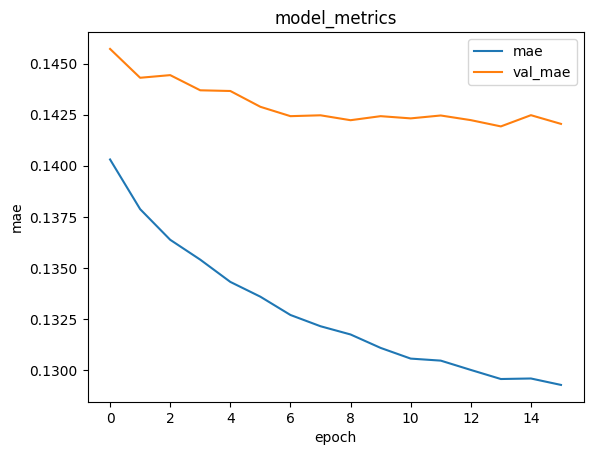

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model_metrics')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['mae', 'val_mae'])
plt.show()

metriks MAE konvergen di sekitar 0.1300 untuk training dan 0.14250 untuk validasi

## Plot Root Mean Squared Error

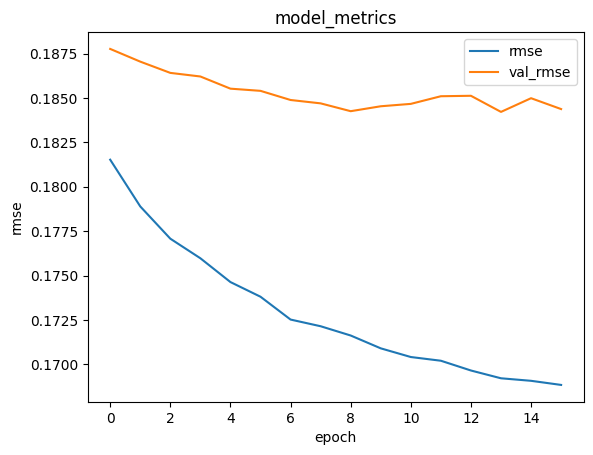

In [ ]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model_metrics')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['rmse', 'val_rmse'])
plt.show()

metriks RMSE konvergen di sekitar 0.1700 untuk training dan 0.1850 untuk validasi